# Binary Classification using LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [2]:
train = pd.read_csv('D:\Preet\Internship Raj Vijtech\Aircraft data & analysis\CSV data files\Train_data_csv.csv')
test = pd.read_csv('D:\Preet\Internship Raj Vijtech\Aircraft data & analysis\CSV data files\Test_data_csv.csv')
truth = pd.read_csv('D:\Preet\Internship Raj Vijtech\Aircraft data & analysis\CSV data files\RUL_data_csv.csv')

# Data Preprocessing

In [3]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)

rul = pd.DataFrame(train.groupby('Unit No.')['Time in Cycles'].max()).reset_index()
rul.columns = ['Unit No.', 'max']
train = train.merge(rul, on=['Unit No.'], how='left')
train = train.drop('Label',axis = 1)
train['RUL'] = train['max'] - train['Time in Cycles']
train = train.drop('max', axis = 1)

In [4]:
# generate label columns for training data
# Label 1 for Binary classification & Label 2 for 3 class classification

w1 = 30
w0 = 15
train['Label1'] = np.where(train['RUL'] <= w1, 1,0)
train['Label2'] = train['Label1']
train.loc[train['RUL'] <= w0, 'Label2'] = 2

# Scale data to values b/w 0 & 1 with Minmax Normalization

train['cycle_norm'] = train['Time in Cycles']
cols_normalize = train.columns.difference(['Unit No.','Time in Cycles','RUL','Label1','Label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train.index)
join_df = train[train.columns.difference(cols_normalize)].join(norm_train_df)
train = join_df.reindex(columns = train.columns)

In [5]:
# Scale the test data like train data

test['cycle_norm'] = test['Time in Cycles']
norm_test = pd.DataFrame(min_max_scaler.transform(test[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test.index)
test_join_df = test[test.columns.difference(cols_normalize)].join(norm_test)
test = test_join_df.reindex(columns = test.columns)
test = test.reset_index(drop=True)

# Use real RUL data(truth dataframe) to generate labels for test data
# generate a column of max cycles for test data

truth.drop(truth.columns[[0]], axis=1, inplace=True)
rul = pd.DataFrame(test.groupby('Unit No.')['Time in Cycles'].max()).reset_index()
rul.columns = ['Unit No.', 'max']
truth.columns = ['more']
truth['Unit No.'] = truth.index + 1
truth['max'] = rul['max'] + truth['more']
truth = truth.drop('more', axis=1)

# generate RUL column for test data

test = test.merge(truth, on=['Unit No.'], how='left')
test['RUL'] = test['max'] - test['Time in Cycles']
test = test.drop('max', axis=1)

# generate label1 & Label2 for test data

test['Label1'] = np.where(test['RUL'] <= w1, 1, 0 )
test['Label2'] = test['Label1']
test.loc[test['RUL'] <= w0, 'Label2'] = 2

# Sequence Generation for LSTM

In [6]:
sequence_length = 50

# define a function to reshape data into (samples, time steps, features) 

def gen_sequence(id_, seq_length, seq_cols):
    
    #make a matrix which contains all the rows of single id
    data_matrix = id_[seq_cols].values
    num_elements = data_matrix.shape[0]
    
    # Iterate over two lists in parallel
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# Make Feature Column

sensor_cols = ['S' + str(i) for i in range(1,22)]
sequence_cols = ['Op.Setting 1', 'Op.Setting 2', 'Op.Setting 3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# sequence generator
seq_gen = (list(gen_sequence(train[train['Unit No.']==id], sequence_length, sequence_cols)) 
           for id in train['Unit No.'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 25)


In [7]:
sequence_length = 50
# function to generate labels same as sequence generator
def gen_labels(id_, seq_length, label):
    
    data_matrix = id_[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels

label_gen = [gen_labels(train[train['Unit No.']==id], sequence_length, ['Label1']) 
             for id in train['Unit No.'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(15631, 1)


# Build LSTM Model

In [8]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

In [9]:
# build LSTM model
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [11]:
# Fit the model

from tensorflow import keras
model_path = 'binary_model.h5'
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(filepath = model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
print(history.history.keys())

Epoch 1/100
75/75 - 17s - loss: 0.2142 - accuracy: 0.9100 - val_loss: 0.0782 - val_accuracy: 0.9680 - 17s/epoch - 229ms/step
Epoch 2/100
75/75 - 11s - loss: 0.0984 - accuracy: 0.9603 - val_loss: 0.0377 - val_accuracy: 0.9847 - 11s/epoch - 142ms/step
Epoch 3/100
75/75 - 12s - loss: 0.0894 - accuracy: 0.9634 - val_loss: 0.0527 - val_accuracy: 0.9821 - 12s/epoch - 156ms/step
Epoch 4/100
75/75 - 11s - loss: 0.0838 - accuracy: 0.9677 - val_loss: 0.0399 - val_accuracy: 0.9847 - 11s/epoch - 152ms/step
Epoch 5/100
75/75 - 11s - loss: 0.0650 - accuracy: 0.9735 - val_loss: 0.0401 - val_accuracy: 0.9834 - 11s/epoch - 146ms/step
Epoch 6/100
75/75 - 10s - loss: 0.0674 - accuracy: 0.9715 - val_loss: 0.0712 - val_accuracy: 0.9642 - 10s/epoch - 139ms/step
Epoch 7/100
75/75 - 12s - loss: 0.0561 - accuracy: 0.9768 - val_loss: 0.0351 - val_accuracy: 0.9859 - 12s/epoch - 154ms/step
Epoch 8/100
75/75 - 12s - loss: 0.0571 - accuracy: 0.9753 - val_loss: 0.0298 - val_accuracy: 0.9859 - 12s/epoch - 162ms/step


# Model Evaluation

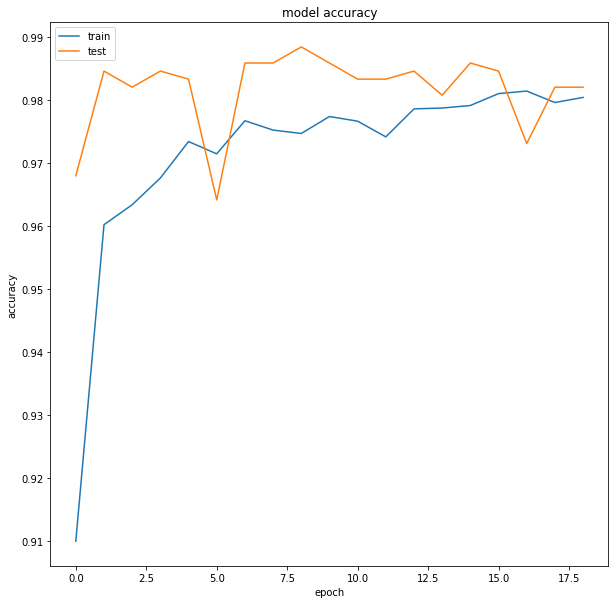

In [12]:
# summarize history for R^2

fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")


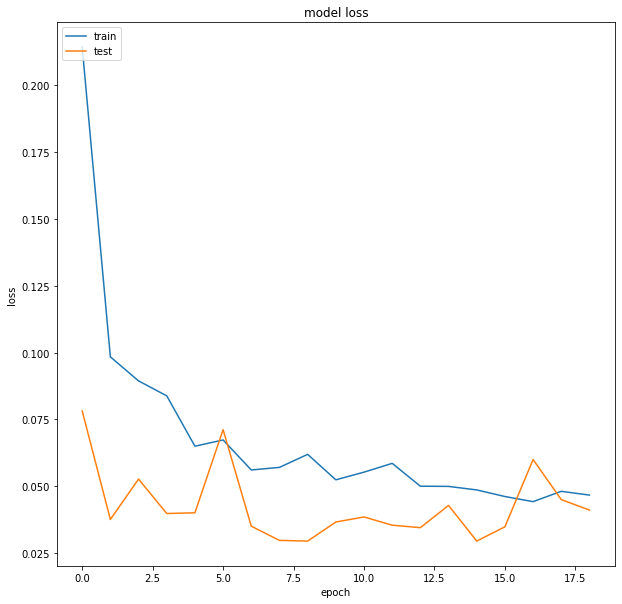

In [13]:
# summarize history for Loss

fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

In [14]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 5s 65ms/step - loss: 0.0377 - accuracy: 0.9845
Accurracy: 0.9845179319381714


In [15]:
# make predictions 
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array



79/79 [==============================] - 6s 63ms/step


In [16]:
# compute confusion matrix
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred.round())
print(cm)



Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12436    95]
 [  147  2953]]


In [17]:
# compute precision and recall
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9688320209973753 
 recall =  0.9525806451612904


# Test data evaluation

In [18]:
# pick the last sequence for each id in the test data

seq_array_test_last = [test[test['Unit No.']==id][sequence_cols].values[-sequence_length:] 
                       for id in test['Unit No.'].unique() if len(test[test['Unit No.']==id]) >= sequence_length]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print(seq_array_test_last.shape)

(93, 50, 25)


In [19]:
#Similarly, pick the labels

y_mask = [len(test[test['Unit No.']==id]) >= sequence_length for id in test['Unit No.'].unique()]
label_array_test_last = test.groupby('Unit No.')['Label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [21]:
# if best iteration's model was saved then load and use it
import os
if os.path.isfile(model_path):
    estimator = load_model(model_path)

In [22]:
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 1s - loss: 0.0662 - accuracy: 0.9677 - 902ms/epoch - 301ms/step
Accurracy: 0.9677419066429138


In [24]:
y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

In [27]:
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test.round())
print(cm)

precision_test = precision_score(y_true_test, y_pred_test.round())
recall_test = recall_score(y_true_test, y_pred_test.round())
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 2 23]]
Precision:  0.9583333333333334 
 Recall:  0.92 
 F1-score: 0.9387755102040817


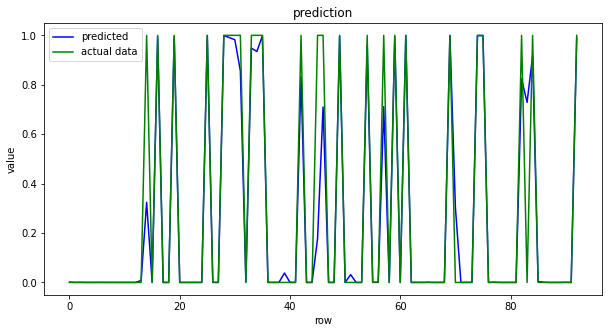

In [28]:
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")